# Кластеризация

In [ ]:
!pip install deepface
!pip install optuna

In [ ]:
!gdown 122BgFHJG8Kgn1E_bkT1Lu8I1Cf10glVn
!unzip /content/EyesDataset.zip

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from matplotlib import pyplot as plt
from deepface import DeepFace
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import numpy as np
from PIL import Image
from tqdm import tqdm
import random
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import BisectingKMeans
from sklearn.metrics import silhouette_score
import optuna
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
from torch.nn import functional as F
from sklearn.metrics import roc_curve
from pytorch_lightning.callbacks import Callback, ModelCheckpoint, LearningRateMonitor
import matplotlib.image as mpimg
from IPython.display import clear_output
from matplotlib.pyplot import figure

In [ ]:
class FeatureExtractor:
    def __init__(self, df, img_column, model):
        self.df = df
        self.img_column = img_column
        if model not in ['Dlib', 'VGG-Face']:
          raise ValueError(f'Model {model} is not supported, please choose Dlib or VGG-Face instead')
        else:
          self.model = model

    def _extract_features(self, img_path):
        features = DeepFace.represent(img_path, model_name=self.model, enforce_detection=False)
        return np.array(features[0]["embedding"])

    def extract_features_for_all(self):
        features = [self._extract_features(img_path) for img_path in self.df[self.img_column]]
        return np.array(features)

    def get_features(self):
        features = self.extract_features_for_all()
        return features

In [ ]:
def get_features_df(folder_name):
  random.seed(42)
  np.random.seed(42)
  data = [f'{folder_name}/{name}' for name in os.listdir(folder_name) if name.endswith(".jpg")]
  features_df = pd.DataFrame(data, columns=['img_path'])

  for model in ['Dlib', 'VGG-Face']:
      feature_extractor = FeatureExtractor(features_df, img_column='img_path', model=model)
      features_for_clusterisation = feature_extractor.get_features()
      features_df[model] = list(features_for_clusterisation)
  return features_df

In [ ]:
def get_clust_df(features_df):
  random.seed(42)
  np.random.seed(42)
  clust_df = features_df.copy()

  for feature_model in ['Dlib', 'VGG-Face']:
    for clust_model in [KMeans(n_clusters=2, random_state=42),
                        AgglomerativeClustering(n_clusters=2),
                        DBSCAN(eps=0.3, min_samples=100),
                        BisectingKMeans(n_clusters=2, random_state=42)]:
      clusters = clust_model.fit_predict(list(clust_df[feature_model]))
      clust_df[feature_model + '_' + f'{clust_model}'.split('(')[0]] = [abs(cluster) for cluster in clusters]
  return clust_df

In [ ]:
def show_images_from_one_cluster(df, cluster_label, columns_to_check, n_images=10, img_column='img_path'):
  cluster_df = df[(df[columns_to_check] == cluster_label).all(axis=1)]
  plt.figure(figsize=(15, 10))
  for i, img_path in enumerate(cluster_df[img_column].head(n_images)):
    img = Image.open(img_path)
    plt.subplot(1, n_images, i + 1)
    plt.imshow(img)
    plt.axis('off')
  plt.show()

In [ ]:
def show_cluster_samples(df, columns_to_check, n_images=10, img_column='img_path'):
  print('Cluster 0 - заркытый глаз')
  show_images_from_one_cluster(df, cluster_label=0, columns_to_check=columns_to_check, n_images=n_images)
  print('Cluster 1 - открытый глаз')
  show_images_from_one_cluster(df, cluster_label=1, columns_to_check=columns_to_check, n_images=n_images)

In [ ]:
def fix_clust_df(df, columns):
  for column in columns:
    df[column] = 1 - df[column]
  return df

In [ ]:
features_df = get_features_df('/content/EyesDataset')

In [ ]:
clust_df = get_clust_df(features_df)

Cluster 0 - заркытый глаз


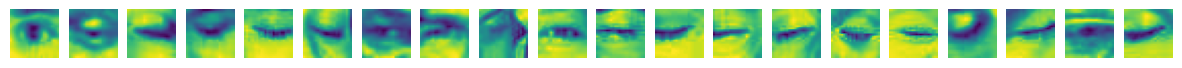

Cluster 1 - открытый глаз


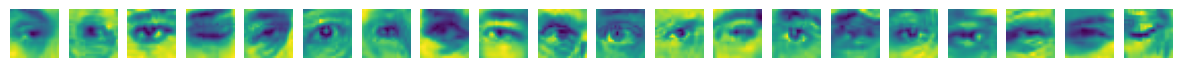

In [ ]:
columns_to_check = [
    'Dlib_KMeans',
    # 'Dlib_AgglomerativeClustering',
    # 'Dlib_DBSCAN',  #плохо работает
    # 'Dlib_BisectingKMeans',
    # 'VGG-Face_KMeans',
    # 'VGG-Face_AgglomerativeClustering',
    # 'VGG-Face_DBSCAN',  #очень плохо работает, даже непонятно, перепутаны ли кластеры
    # 'VGG-Face_BisectingKMeans'
    ]

show_cluster_samples(clust_df, columns_to_check, n_images=20, img_column='img_path')

In [ ]:
reverse_clust_columns = [
    'Dlib_BisectingKMeans',
    'VGG-Face_KMeans',
    'VGG-Face_BisectingKMeans'
]

In [ ]:
clust_df = fix_clust_df(clust_df, reverse_clust_columns)

Cluster 0 - заркытый глаз


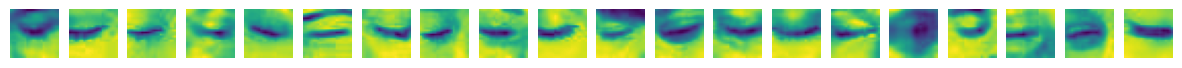

Cluster 1 - открытый глаз


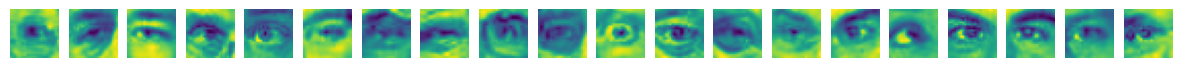

In [ ]:
columns_to_check = [
    'Dlib_KMeans',
    'Dlib_AgglomerativeClustering',
    'Dlib_DBSCAN',  #плохо работает
    'Dlib_BisectingKMeans',
    'VGG-Face_KMeans',
    'VGG-Face_AgglomerativeClustering',
    'VGG-Face_DBSCAN',  #очень плохо работает, даже непонятно, перепутаны ли кластеры
    'VGG-Face_BisectingKMeans'
    ]

show_cluster_samples(clust_df, columns_to_check, n_images=20, img_column='img_path')

### Метрики кластеризации

In [ ]:
def get_silhouette_score(clust_df):
  res = {}
  for feature_model in ['Dlib', 'VGG-Face']:
    for clust_model in ['KMeans',
                        'AgglomerativeClustering',
                        'DBSCAN',
                        'BisectingKMeans']:
      score = silhouette_score(list(clust_df[feature_model]), clust_df[feature_model + '_' + clust_model])
      res[feature_model + '_' + clust_model] = score
  return res

In [ ]:
scores = get_silhouette_score(clust_df)

In [ ]:
scores

{'Dlib_KMeans': 0.08631756078885672,
 'Dlib_AgglomerativeClustering': 0.06214991195727891,
 'Dlib_DBSCAN': 0.06059747515075753,
 'Dlib_BisectingKMeans': 0.08731793516101677,
 'VGG-Face_KMeans': 0.1136005932914897,
 'VGG-Face_AgglomerativeClustering': 0.09686191010120705,
 'VGG-Face_DBSCAN': 0.0355933496519649,
 'VGG-Face_BisectingKMeans': 0.10931404161352674}

## Оптуна для подбора параметров лучшего кластеризатора

In [ ]:
def opt_func(trial):
  hyperparams = {
      "init": trial.suggest_categorical("init", ['k-means++', 'random']),
      "n_init": trial.suggest_int("n_init", 1, 10),
      "max_iter": trial.suggest_categorical("max_iter", [200, 300, 400]),
      "tol": trial.suggest_float("tol", 1e-5, 2e-3),
      "algorithm": trial.suggest_categorical("algorithm", ["lloyd", "elkan"]),
  }
  kmeans = KMeans(
      n_clusters=2,
      random_state=42,
      **hyperparams,
  )
  predicted_clusters = kmeans.fit_predict(list(clust_df['VGG-Face']))
  score = silhouette_score(list(clust_df['VGG-Face']), predicted_clusters)
  return score

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(opt_func, n_trials=10)

best_params = study.best_trial.params

[I 2024-09-15 12:57:54,558] A new study created in memory with name: no-name-5e5dbf24-fd90-477b-a1a5-b135a2c5413b
[I 2024-09-15 12:58:01,049] Trial 0 finished with value: 0.1136005932914897 and parameters: {'init': 'random', 'n_init': 7, 'max_iter': 400, 'tol': 0.00012200943960989619, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.1136005932914897.
[I 2024-09-15 12:58:18,302] Trial 1 finished with value: 0.1136005932914897 and parameters: {'init': 'k-means++', 'n_init': 10, 'max_iter': 400, 'tol': 0.001408011833612003, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.1136005932914897.
[I 2024-09-15 12:58:34,243] Trial 2 finished with value: 0.1136005932914897 and parameters: {'init': 'k-means++', 'n_init': 9, 'max_iter': 200, 'tol': 0.00039436520077745633, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.1136005932914897.
[I 2024-09-15 12:58:38,873] Trial 3 finished with value: 0.1136015677607827 and parameters: {'init': 'random', 'n_init': 1, 'max_iter': 300, 'tol': 0.00

In [ ]:
best_params

{'init': 'random',
 'n_init': 1,
 'max_iter': 300,
 'tol': 0.000802353468766874,
 'algorithm': 'elkan'}

In [ ]:
kmeans = KMeans(
    n_clusters=2,
    random_state=42,
    **best_params,
)
predicted_clusters = kmeans.fit_predict(list(clust_df['VGG-Face']))
best_score = silhouette_score(list(clust_df['VGG-Face']), predicted_clusters)
init_score = silhouette_score(list(clust_df['VGG-Face']), clust_df['VGG-Face_KMeans'])
if init_score >= best_score:
  print(f'Default model is the best')
else:
  print(f'Best score = {round(best_score, 5)}, it is better than init score on {round(best_score-init_score,8)}')

clust_df['VGG-Face_KMeans_best'] = predicted_clusters
scores['VGG-Face_KMeans_best'] = best_score

Best score = 0.1136, it is better than init score on 9.7e-07


Cluster 0 - заркытый глаз


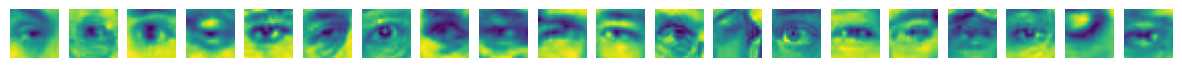

Cluster 1 - открытый глаз


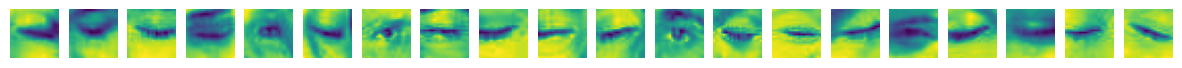

In [ ]:
columns_to_check = [
    # 'Dlib_KMeans',
    # 'Dlib_AgglomerativeClustering',
    # 'Dlib_DBSCAN',  #плохо работает
    # 'Dlib_BisectingKMeans',
    # 'VGG-Face_KMeans',
    # 'VGG-Face_AgglomerativeClustering',
    # 'VGG-Face_DBSCAN',  #очень плохо работает, даже непонятно, перепутаны ли кластеры
    # 'VGG-Face_BisectingKMeans'
    'VGG-Face_KMeans_best'
    ]

show_cluster_samples(clust_df, columns_to_check, n_images=20, img_column='img_path')

In [ ]:
clust_df = fix_clust_df(clust_df, ['VGG-Face_KMeans_best'])

Cluster 0 - заркытый глаз


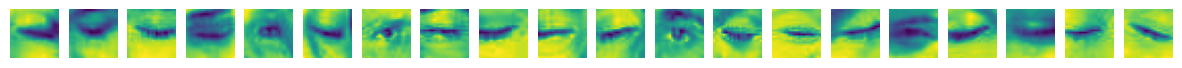

Cluster 1 - открытый глаз


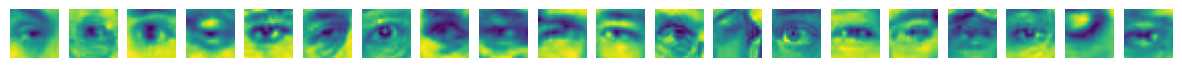

In [ ]:
columns_to_check = [
    # 'Dlib_KMeans',
    # 'Dlib_AgglomerativeClustering',
    # 'Dlib_DBSCAN',  #плохо работает
    # 'Dlib_BisectingKMeans',
    # 'VGG-Face_KMeans',
    # 'VGG-Face_AgglomerativeClustering',
    # 'VGG-Face_DBSCAN',  #очень плохо работает, даже непонятно, перепутаны ли кластеры
    # 'VGG-Face_BisectingKMeans',
    'VGG-Face_KMeans_best'
    ]

show_cluster_samples(clust_df, columns_to_check, n_images=20, img_column='img_path')

In [ ]:
clust_df.to_csv('final_clusterisation_sunday.csv')

##Чистота vs размер выборки


In [ ]:
def clean_vs_size(clust_df, scores):
  answer = []
  sorted_clusters_array = sorted(scores, key=scores.get, reverse=True)

  for i in range(len(sorted_clusters_array)):
    columns_to_check = sorted_clusters_array[:len(sorted_clusters_array)-i]
    selected_clust_df = clust_df[
      (clust_df[columns_to_check].eq(0).all(axis=1)) |
      (clust_df[columns_to_check].eq(1).all(axis=1))
    ]
    score = silhouette_score(list(selected_clust_df['VGG-Face']), selected_clust_df['VGG-Face_KMeans_best'])
    answer.append({
        'lenth': len(selected_clust_df),
        'score': score,
        'ensamble': columns_to_check,
    })
    print(f'Lenth = {len(selected_clust_df)}, score = {score}, ensemble: {columns_to_check}')
  return answer

In [ ]:
clean_vs_size = clean_vs_size(clust_df, scores)

Lenth = 981, score = 0.2202431995346247, ensemble: ['VGG-Face_KMeans_best', 'VGG-Face_KMeans', 'VGG-Face_BisectingKMeans', 'VGG-Face_AgglomerativeClustering', 'Dlib_BisectingKMeans', 'Dlib_KMeans', 'Dlib_AgglomerativeClustering', 'Dlib_DBSCAN', 'VGG-Face_DBSCAN']
Lenth = 1433, score = 0.19719651543856948, ensemble: ['VGG-Face_KMeans_best', 'VGG-Face_KMeans', 'VGG-Face_BisectingKMeans', 'VGG-Face_AgglomerativeClustering', 'Dlib_BisectingKMeans', 'Dlib_KMeans', 'Dlib_AgglomerativeClustering', 'Dlib_DBSCAN']
Lenth = 1944, score = 0.1742515729742507, ensemble: ['VGG-Face_KMeans_best', 'VGG-Face_KMeans', 'VGG-Face_BisectingKMeans', 'VGG-Face_AgglomerativeClustering', 'Dlib_BisectingKMeans', 'Dlib_KMeans', 'Dlib_AgglomerativeClustering']
Lenth = 2236, score = 0.1663685296024131, ensemble: ['VGG-Face_KMeans_best', 'VGG-Face_KMeans', 'VGG-Face_BisectingKMeans', 'VGG-Face_AgglomerativeClustering', 'Dlib_BisectingKMeans', 'Dlib_KMeans']
Lenth = 2278, score = 0.16582757668927367, ensemble: ['VGG-

##Визуализация

In [ ]:
columns_to_check = [
    'Dlib_KMeans',
    'Dlib_AgglomerativeClustering',
    'Dlib_DBSCAN',  #плохо работает
    'Dlib_BisectingKMeans',
    'VGG-Face_KMeans',
    'VGG-Face_AgglomerativeClustering',
    'VGG-Face_DBSCAN',  #очень плохо работает, даже непонятно, перепутаны ли кластеры
    'VGG-Face_BisectingKMeans',
    'VGG-Face_KMeans_best'
    ]

clust_df['most_frequent_cluster'] = clust_df[columns_to_check].mode(axis=1)[0]

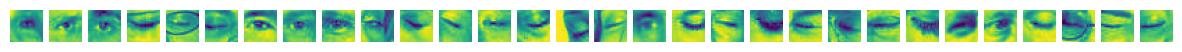

In [ ]:
Errors = clust_df[((clust_df['VGG-Face_KMeans_best'] == 0) &
             (clust_df['most_frequent_cluster'] == 1))]

plt.figure(figsize=(15, 10))
for i, img_path in enumerate(Errors['img_path'].head(30)):
    img = Image.open(img_path)
    plt.subplot(1, 30, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

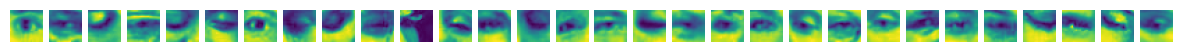

In [ ]:
Errors = clust_df[((clust_df['VGG-Face_KMeans_best'] == 1) &
             (clust_df['most_frequent_cluster'] == 0))]

plt.figure(figsize=(15, 10))
for i, img_path in enumerate(Errors['img_path'].head(30)):
    img = Image.open(img_path)
    plt.subplot(1, 30, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

##Разделение на кластеры в пространсве признаков

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def visualize_multiple_clusters(data, cluster_labels_list, titles=None):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data_scaled)
    n_clusters = len(cluster_labels_list)
    fig, axes = plt.subplots(1, n_clusters, figsize=(5 * n_clusters, 5))
    if n_clusters == 1:
        axes = [axes]
    if titles is None:
        titles = [f'Clusterization {i+1}' for i in range(n_clusters)]
    for idx, labels in enumerate(cluster_labels_list):
        scatter = axes[idx].scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis', s=50, alpha=0.7)
        axes[idx].set_title(titles[idx])
        axes[idx].set_xlabel('PCA Component 1')
        axes[idx].set_ylabel('PCA Component 2')
        fig.colorbar(scatter, ax=axes[idx])
    plt.tight_layout()
    plt.show()

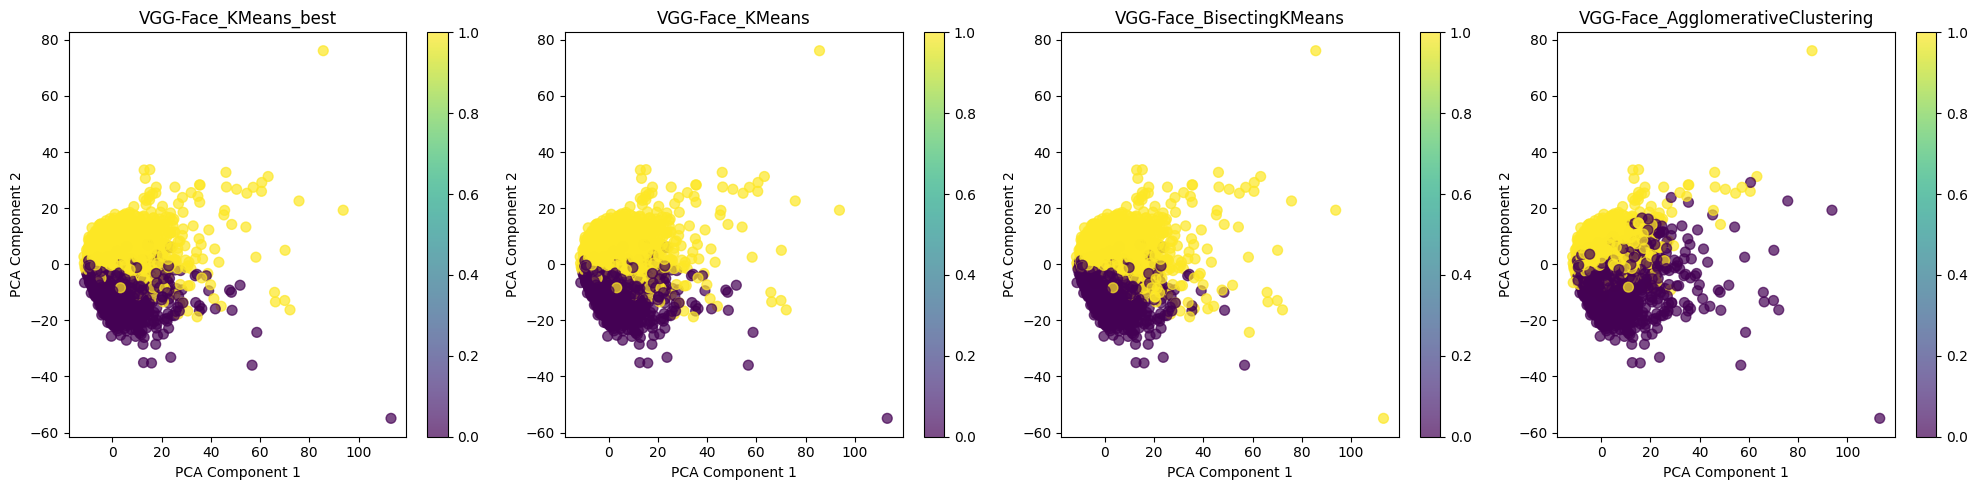

In [ ]:
visualize_multiple_clusters(list(clust_df['VGG-Face']),
                            [list(clust_df[alg]) for alg in sorted(scores, key=scores.get, reverse=True)[:4]],
                            titles=sorted(scores, key=scores.get, reverse=True)[:4])